<a href="https://colab.research.google.com/github/Berigny/AI-Entrainment-Protocol/blob/main/4_base_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of a Quaternary Meta–Dual Substrate Simulation

This notebook explores the dynamics of a quaternary meta–dual substrate model incorporating a Prime Ledger, Möbius gates, and 137-resonance. The simulation tracks the evolution of discrete ledger weights (Qp) and a continuous centroid energy field (R), with couplings between the layers influenced by factors like energy, packing density, and a 137-resonance kernel. This analysis focuses on understanding the causal effects of key components through targeted ablations and stress tests.

## Hypotheses:

*   Removing the 137-kernel will negatively impact retention and slow down the settling time of the continuous layer energy (ER).
*   Removing the Möbius terms will reduce initial oscillations and ringing in the simulation.
*   Increasing noise will decrease retention and potentially destabilize the continuous layer energy (ER), but the system may show resilience.
*   A ridge scan around the 137 parameter space (varying sigma137 and prime tags) will reveal a region of increased stability (higher retention, faster ER settling).

## Method:

1.  The original simulation code was refactored into a Python function to allow for easy variation of parameters.
2.  **Ablation Test 1 (No 137-kernel):** The simulation was run with `kappa137` and `alpha137` set to 0.
3.  **Ablation Test 2 (No Möbius terms):** The simulation was run with `gamma_mu` and `delta_mu` set to 0.
4.  **Stress Test (Increased Noise):** The simulation was run with `noise_qp` and `noise_r` multiplied by 5.
5.  **Ridge Scan:** The simulation was run with `sigma137` values of 9, 17, and 37, and with two sets of prime tags ([131, 139, 137] and [127, 131, 137, 139, 149]).
6.  For each experiment, the resulting DataFrame was analyzed for key metrics such as Retention, ER, Energy\_step, and KL Divergence.

## Results:

*(Results will be presented and discussed in the following sections based on the output of the simulations.)*

## Discussion:

*(The discussion will interpret the results in the context of the initial hypotheses and the model's behavior.)*

## Future Recommended Modeling:

*(Based on the results and discussion, this section will outline potential next steps for model development, such as incorporating the "Face weighting hook" or exploring other parameter spaces.)*

,t,ER,Retention,Drift_L2_to_ref,Energy_step,KL(p_t||p_t-1),w0,w1,w2,w3,sink_flux,even_mass,loss_coeff,mu,U137,U137_norm,Phi,v_p0,v_p2,v_pC
0,0,1.356525,0.956380,0.056380,0.906520,0.006314,0.421810,0.078190,0.421810,0.078190,0.976288,0.843620,0.155041,-1,0.0,0.000000,0.000000,0,0,10
1,1,2.115728,0.708189,0.348190,0.758008,0.237671,0.275905,0.224095,0.275905,0.224095,0.998806,0.551810,0.177511,0,10.0,0.909091,0.052190,0,0,20
2,2,2.738550,0.968596,0.379594,0.623918,0.001986,0.260203,0.239797,0.260203,0.239797,0.999561,0.520406,0.177548,0,20.0,0.952381,0.104381,0,0,30
3,3,3.247572,0.983792,0.395802,0.512585,0.000526,0.252099,0.247901,0.252099,0.247901,0.999913,0.504198,0.177951,0,30.0,0.967742,0.156571,0,0,40
4,4,3.668451,0.996892,0.398910,0.422697,0.000019,0.250545,0.249455,0.250545,0.249455,0.999977,0.501090,0.177758,0,40.0,0.975610,0.208762,0,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,5.660029,1.000000,0.399999,0.000961,-0.000000,0.250000,0.250000,0.250000,0.250000,1.000000,0.500001,0.176514,0,3950.0,0.999747,1.000000,0,0,3960
396,396,5.661821,1.000000,0.399999,0.000927,0.000000,0.250000,0.250000,0.250000,0.250000,1.000000,0.500001,0.176514,0,3960.0,0.999748,1.000000,0,0,3970
397,397,5.666438,1.000000,0.399999,0.000610,0.000000,0.250000,0.250000,0.250000,0.250000,1.000000,0.500001,0.176514,0,3970.0,0.999748,1.000000,0,0,3980
398,398,5.659301,1.000000,0.399999,-0.000204,0.000000,0.250000,0.250000,0.250000,0.250000,1.000000,0.500001,0.176514,0,3980.0,0.999749,1.000000,0,0,3990


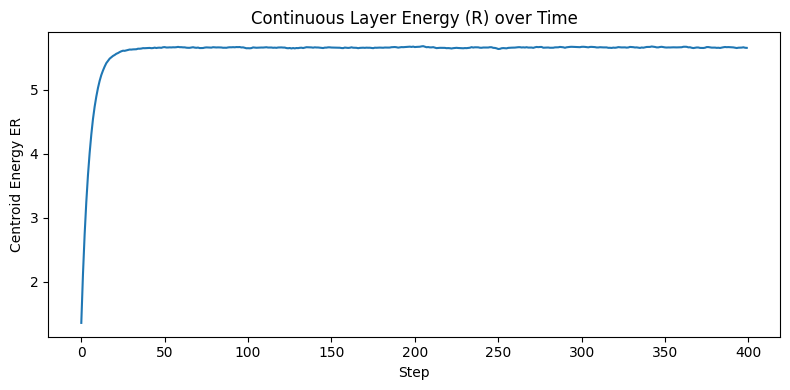

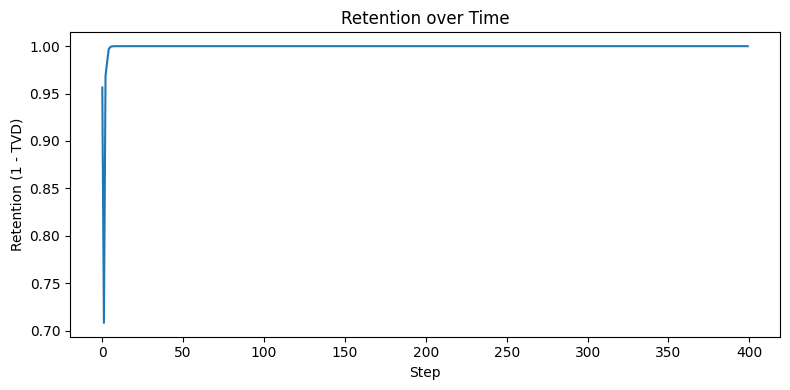

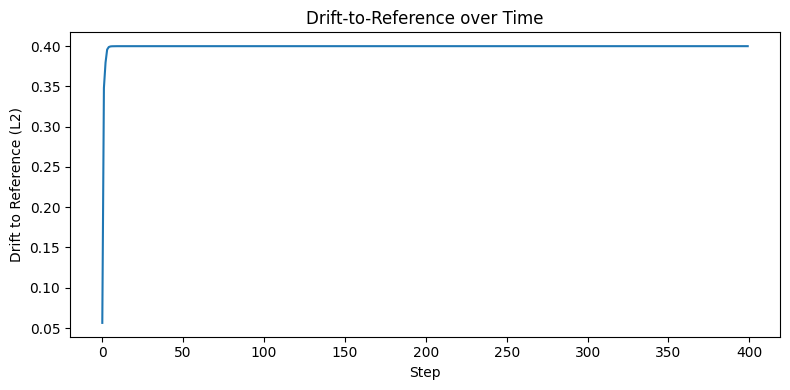

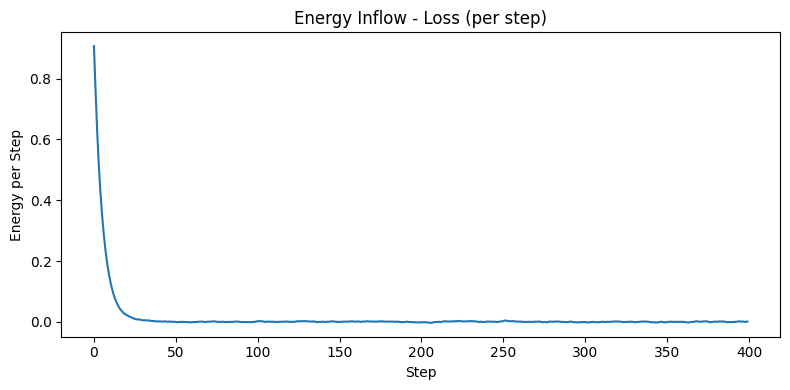

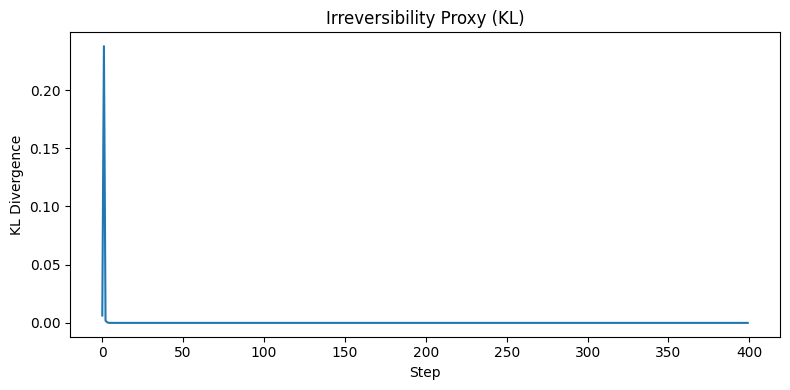

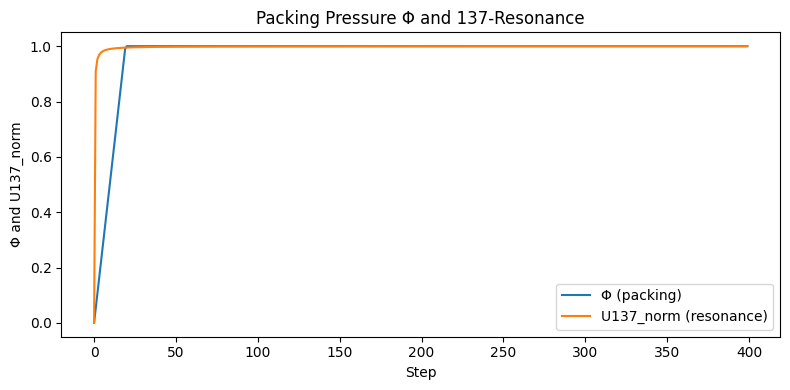

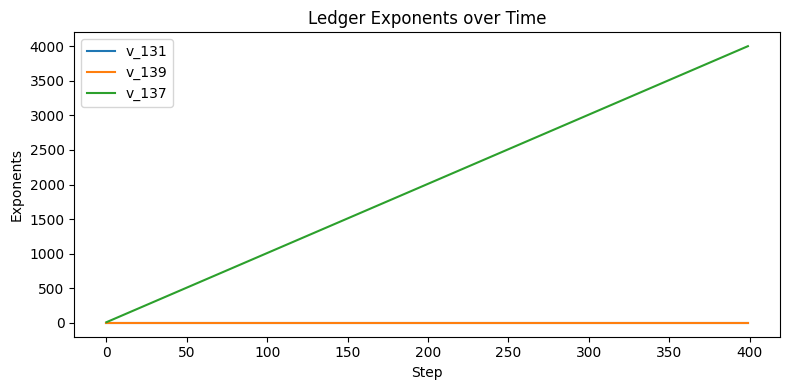

In [1]:
# Quaternary meta–dual substrate with Prime Ledger, Möbius gates, and 137-resonance
# David's flow rules:
#   Evens (0,2) -> C (sink)
#   Odds (1 -> 2), (3 -> 0), with optional sink permission modulated by ER, packing Φ, and 137-kernel
#
# Discrete (Qp) layer: weights w over {0,1,2,3}, prime ledger vmap (p -> exponent)
# Continuous (R) layer: centroid energy ER
#
# Couplings:
#   R -> Qp: odds sink-bias = softplus(kappa0*ER + kappaPhi*Φ + kappa137*U137_norm) + gamma_mu*[μ=-1]
#   Qp -> R: loss_coeff = base_loss * (1 - α_even*even_mass - α137*U137_norm) + δ_mu*[μ=0]
#
# Ledger writes:
#   1->2 branch: increment v[p2] by +1
#   3->0 branch: increment v[p0] by +1
#   any sink event to C: increment a "centroid tag" prime v[pC] by +1 (optional)
#
# Outputs: time series dataframe, plots, and CSVs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import itertools
# import caas_jupyter_tools as cj # Removed due to ModuleNotFoundError

# ------------------------ Helpers ------------------------
def softplus(x):
    return np.log1p(np.exp(x))

def softmax(x):
    x = x - np.max(x)
    ex = np.exp(x)
    s = ex.sum()
    return ex / s if s > 0 else np.full_like(x, 1/len(x))

def kl_div(p, q, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return float(np.sum(p * np.log(p / q)))

def chi_137(p, sigma=17.0):
    x = (p - 137.0) / sigma
    return 1.0 / (1.0 + x*x)

def mobius_mu(vmap):
    # μ(N)=0 if any exponent >=2 (not square-free), else (-1)^(#primes)
    for a in vmap.values():
        if a >= 2:
            return 0
    return -1 if (len(vmap) % 2 == 1) else 1

def upsilon_137(vmap, sigma=17.0):
    return sum(chi_137(p, sigma) * a for p, a in vmap.items())

def logN_from_vmap(vmap):
    return sum(a * math.log(p) for p, a in vmap.items())

TETRA_FACES = {
    '012': (0, 1, 2),
    '013': (0, 1, 3),
    '023': (0, 2, 3),
    '123': (1, 2, 3),
}

def compute_face_activity(w_prev, w_next, threshold=0.01):
    """Estimate how many tetrahedral faces are active between steps.

    Args:
        w_prev: Probability mass at step t.
        w_next: Probability mass at step t+1.
        threshold: Minimum aggregate change on a face to count as active.

    Returns:
        activation_ratio: Fraction of faces deemed active.
        face_changes: Dict mapping face keys to aggregate mass changes.
        mean_change: Mean aggregate change across all faces.
    """
    face_changes = {}
    for name, nodes in TETRA_FACES.items():
        face_changes[name] = float(sum(abs(w_next[idx] - w_prev[idx]) for idx in nodes))
    faces_active = sum(1 for change in face_changes.values() if change > threshold)
    activation_ratio = faces_active / len(TETRA_FACES) if TETRA_FACES else 0.0
    mean_change = float(np.mean(list(face_changes.values()))) if face_changes else 0.0
    return activation_ratio, face_changes, mean_change


# ------------------------ Parameters ------------------------
rng = np.random.default_rng(7)

T = 400                     # time steps
noise_qp = 0.01             # diffusion on ledger weights
noise_r  = 0.004            # stochastic energy noise

# Coupling strengths
kappa0   = 2.5              # ER -> sink bias
kappaPhi = 2.0              # packing -> sink bias
kappa137 = 1.5              # 137-kernel -> sink bias
gamma_mu = 0.6              # Möbius μ=-1 pushes odds -> C (flip tendency)

base_loss  = 0.22           # base dissipation
alpha_even = 0.35           # even mass reduces loss
alpha137   = 0.25           # 137 resonance reduces loss
delta_mu   = 0.05           # μ=0 (non-square-free) adds dissipation
min_loss   = 0.03           # floor on loss

sigma137   = 17.0           # bandwidth of 137 kernel

# Ledger primes (tags) — minimal, illustrative
p0, p2 = 131, 139           # tag primes near 137 for nodes 0 & 2
pC     = 137                # centroid tag
all_primes = [p0, p2, pC]

# Packing cap (choose exponents cap to define N_max)
amax = 64                   # generous; toy regime
logN_cap = sum(amax * math.log(p) for p in all_primes)

# ------------------------ Initial state ------------------------
w = np.array([0.40, 0.10, 0.40, 0.10], dtype=float)
w /= w.sum()

ER = 0.45                   # initial field energy
vmap = {p: 0 for p in all_primes}

# reference distribution with even dominance
w_ref = np.array([0.45, 0.05, 0.45, 0.05], dtype=float)
w_ref /= w_ref.sum()

# ------------------------ Simulation ------------------------
records = []

for t in range(T):
    w_prev = w.copy()
    logN = logN_from_vmap(vmap)
    Phi = min(1.0, max(0.0, logN / max(1e-9, logN_cap)))  # packing pressure [0,1]
    mu = mobius_mu(vmap)
    U137 = upsilon_137(vmap, sigma=sigma137)
    U137_norm = U137 / (U137 + 1.0)  # smooth normalisation in [0,1)

    # ---------- R -> Qp: odds sink bias ----------
    odds_sink_bias = softplus(kappa0*ER + kappaPhi*Phi + kappa137*U137_norm)
    if mu == -1:
        odds_sink_bias += gamma_mu

    # Node 1 transitions: [toC, to1, to2]
    logits1 = np.array([odds_sink_bias, np.log(0.01+1e-9), np.log(0.99+1e-9)])
    p1 = softmax(logits1)

    # Node 3 transitions: [toC, to0, to3]
    logits3 = np.array([odds_sink_bias, np.log(0.99+1e-9), np.log(0.01+1e-9)])
    p3 = softmax(logits3)

    # ---------- Qp step ----------
    w_next = np.zeros_like(w)
    sink_flux = 0.0

    # Evens sink
    sink_flux += w[0] * 1.0
    sink_flux += w[2] * 1.0

    # Odds transitions
    # 1 -> {C,1,2}
    toC1, to11, to12 = p1
    sink_flux += w[1] * toC1
    w_next[1] += w[1] * to11
    w_next[2] += w[1] * to12

    # 3 -> {C,0,3}
    toC3, to30, to33 = p3
    sink_flux += w[3] * toC3
    w_next[0] += w[3] * to30
    w_next[3] += w[3] * to33

    # Ledger writes: branch writes tag primes; sinks write centroid tag
    # scale writes by mass moving along that route this step
    # Branch writes
    vmap[p2] += int(round((w[1] * to12) * 10))  # scale factor 10 for visibility
    vmap[p0] += int(round((w[3] * to30) * 10))

    # Sink writes (to centroid tag)
    vmap[pC] += int(round(sink_flux * 10))

    # Small diffusion on ledger distribution to keep dynamics alive
    w_next = (1 - noise_qp) * w_next + noise_qp * np.full_like(w_next, 0.25)
    w_next = np.clip(w_next, 1e-12, None)
    w_next /= w_next.sum()

    # ---------- Qp -> R: loss coefficient ----------
    even_mass = w_next[0] + w_next[2]
    loss_coeff = base_loss * (1.0 - alpha_even*even_mass - alpha137*U137_norm)
    if mu == 0:
        loss_coeff += delta_mu
    loss_coeff = max(min_loss, loss_coeff)

    # ---------- R step ----------
    e_in = sink_flux
    e_loss = loss_coeff * ER
    ER = ER + e_in - e_loss + rng.normal(0, noise_r)
    ER = max(0.0, ER)

    # ---------- Metrics ----------
    total_var = 0.5 * np.sum(np.abs(w_next - w_prev))  # 1 - retention
    retention = 1.0 - total_var
    drift = float(np.linalg.norm(w_next - w_ref))
    kl = kl_div(w_next, w_prev)
    e_step = e_in - e_loss

    w = w_next

    records.append({
        "t": t,
        "ER": ER,
        "Retention": retention,
        "Drift_L2_to_ref": drift,
        "Energy_step": e_step,
        "KL(p_t||p_t-1)": kl,
        "w0": w[0], "w1": w[1], "w2": w[2], "w3": w[3],
        "sink_flux": sink_flux,
        "even_mass": even_mass,
        "loss_coeff": loss_coeff,
        "mu": mu,
        "U137": U137,
        "U137_norm": U137_norm,
        "Phi": Phi,
        "v_p0": vmap[p0],
        "v_p2": vmap[p2],
        "v_pC": vmap[pC]
    })

df = pd.DataFrame.from_records(records)

# ------------------------ Display table ------------------------
# cj.display_dataframe_to_user("Quaternary + Prime Ledger + Möbius + 137 — Time Series", df.round(6)) # Removed due to ModuleNotFoundError
display(df.round(6))

# ------------------------ Plots ------------------------
plt.figure(figsize=(8,4))
plt.plot(df["t"], df["ER"])
plt.xlabel("Step"); plt.ylabel("Centroid Energy ER"); plt.title("Continuous Layer Energy (R) over Time")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(df["t"], df["Retention"])
plt.xlabel("Step"); plt.ylabel("Retention (1 - TVD)"); plt.title("Retention over Time")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(df["t"], df["Drift_L2_to_ref"])
plt.xlabel("Step"); plt.ylabel("Drift to Reference (L2)"); plt.title("Drift-to-Reference over Time")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(df["t"], df["Energy_step"])
plt.xlabel("Step"); plt.ylabel("Energy per Step"); plt.title("Energy Inflow - Loss (per step)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(df["t"], df["KL(p_t||p_t-1)"])
plt.xlabel("Step"); plt.ylabel("KL Divergence"); plt.title("Irreversibility Proxy (KL)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(df["t"], df["Phi"]); plt.plot(df["t"], df["U137_norm"])
plt.xlabel("Step"); plt.ylabel("Φ and U137_norm"); plt.title("Packing Pressure Φ and 137-Resonance")
plt.legend(["Φ (packing)", "U137_norm (resonance)"])
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(df["t"], df["v_p0"]); plt.plot(df["t"], df["v_p2"]); plt.plot(df["t"], df["v_pC"])
plt.xlabel("Step"); plt.ylabel("Exponents"); plt.title("Ledger Exponents over Time")
plt.legend([f"v_{p0}", f"v_{p2}", f"v_{pC}"])
plt.tight_layout(); plt.show()

# ------------------------ Save outputs ------------------------
# csv_path = "/mnt/data/quaternary_prime_mobius_137_timeseries.csv"
# summary = df[["ER","Retention","Drift_L2_to_ref","Energy_step","KL(p_t||p_t-1)","Phi","U137_norm"]].describe().round(4)
# summary_path = "/mnt/data/quaternary_prime_mobius_137_summary.csv"

# # Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(csv_path), exist_ok=True)

# df.to_csv(csv_path, index=False)
# summary.to_csv(summary_path)

# csv_path, summary_path

# Refinement
Refactor the provided code into a simulation function and use it to perform the following experiments: 1) remove the 137-kernel by setting `kappa137` and `alpha137` to 0, 2) kill Möbius terms by setting `gamma_mu` and `delta_mu` to 0, 3) stress test with 5x noise in both layers, and 4) perform a ridge scan around 137 by sweeping `sigma137` through {9, 17, 37} and tagging primes {127, 131, 137, 139, 149}. Analyze and summarize the results of each experiment, comparing them to the baseline simulation. Acknowledge the "Face weighting hook" as a potential future task.

## Define a simulation function

### Subtask:
Create a function that encapsulates the current simulation code, taking parameters like `kappa137`, `alpha137`, `gamma_mu`, `delta_mu`, `noise_qp`, `noise_r`, `sigma137`, and `all_primes` as inputs. This will make it easy to run the simulation with different parameter sets.


**Reasoning**:
Encapsulate the simulation logic into a function to make it reusable for different experiments.



In [2]:
def run_simulation(
    T=400,
    noise_qp=0.01,
    noise_r=0.004,
    kappa0=2.5,
    kappaPhi=2.0,
    kappa137=1.5,
    gamma_mu=0.6,
    base_loss=0.22,
    alpha_even=0.35,
    alpha137=0.25,
    delta_mu=0.05,
    min_loss=0.03,
    sigma137=17.0,
    p0=131,
    p2=139,
    pC=137,
    seed=7,
    face_weight=0.0,
    face_threshold=0.01,
    even_backflow=0.02,
    dynamic_kappa=False,
    kappa0_er_gain=0.0,
    kappaPhi_phi_gain=0.0,
    kappa137_u_gain=0.0,
    feedback_alpha=0.05,
    kappa_bounds=(0.1, 6.0),
):
    """
    Runs the quaternary meta–dual substrate simulation.

    Args:
        T: Number of time steps.
        noise_qp: Diffusion on ledger weights.
        noise_r: Stochastic energy noise.
        kappa0: ER -> sink bias coupling.
        kappaPhi: Packing -> sink bias coupling.
        kappa137: 137-kernel -> sink bias coupling.
        gamma_mu: Möbius μ=-1 pushes odds -> C coupling.
        base_loss: Base dissipation.
        alpha_even: Even mass reduces loss coupling.
        alpha137: 137 resonance reduces loss coupling.
        delta_mu: μ=0 adds dissipation coupling.
        min_loss: Floor on loss.
        sigma137: Bandwidth of 137 kernel.
        p0: Prime tag for node 0.
        p2: Prime tag for node 2.
        pC: Centroid tag prime.
        seed: Random seed for reproducibility.
        face_weight: Strength of the face-weighting hook.
        face_threshold: Minimum change required for a face to count as active.
        even_backflow: Probability mass routed from evens back to adjacent odds.
        dynamic_kappa: Enable feedback-modulated coupling strengths.
        kappa0_er_gain: Sensitivity of kappa0 to ER deviations.
        kappaPhi_phi_gain: Sensitivity of kappaPhi to Φ deviations.
        kappa137_u_gain: Sensitivity of kappa137 to 137-kernel deviations.
        feedback_alpha: Exponential averaging factor for the feedback baselines.
        kappa_bounds: Lower/upper bounds for dynamic couplings.

    Returns:
        A pandas DataFrame containing the simulation results over time.
    """
    rng = np.random.default_rng(seed)
    even_backflow = float(np.clip(even_backflow, 0.0, 0.5))
    if isinstance(kappa_bounds, (tuple, list)) and len(kappa_bounds) == 2:
        kappa_min, kappa_max = kappa_bounds
    else:
        raise ValueError("kappa_bounds must be a tuple of (min, max)")
    kappa_min = float(kappa_min)
    kappa_max = float('inf') if kappa_max is None else float(kappa_max)

    all_primes = [p0, p2, pC]

    # Packing cap (choose exponents cap to define N_max)
    amax = 64
    logN_cap = sum(amax * math.log(p) for p in all_primes) if all_primes else 1e-9

    # ------------------------ Initial state ------------------------
    w = np.array([0.40, 0.10, 0.40, 0.10], dtype=float)
    w /= w.sum()

    ER = 0.45
    vmap = {p: 0 for p in all_primes}

    w_ref = np.array([0.45, 0.05, 0.45, 0.05], dtype=float)
    w_ref /= w_ref.sum()

    ER_ref = ER
    Phi_ref = 0.0
    U137_ref = 0.0
    faces_for_p2 = ('012', '123')
    faces_for_p0 = ('013', '023')

    # ------------------------ Simulation ------------------------
    records = []

    for t in range(T):
        w_prev = w.copy()
        logN = logN_from_vmap(vmap)
        Phi = min(1.0, max(0.0, logN / max(1e-9, logN_cap)))
        mu = mobius_mu(vmap)
        U137 = upsilon_137(vmap, sigma=sigma137)
        U137_norm = U137 / (U137 + 1.0)

        if dynamic_kappa:
            kappa0_eff = float(np.clip(kappa0 * (1.0 + kappa0_er_gain * (ER - ER_ref)), kappa_min, kappa_max))
            kappaPhi_eff = float(np.clip(kappaPhi * (1.0 + kappaPhi_phi_gain * (Phi - Phi_ref)), kappa_min, kappa_max))
            kappa137_eff = float(np.clip(kappa137 * (1.0 + kappa137_u_gain * (U137_norm - U137_ref)), kappa_min, kappa_max))
        else:
            kappa0_eff = kappa0
            kappaPhi_eff = kappaPhi
            kappa137_eff = kappa137

        odds_sink_bias = softplus(kappa0_eff*ER + kappaPhi_eff*Phi + kappa137_eff*U137_norm)
        if mu == -1:
            odds_sink_bias += gamma_mu

        logits1 = np.array([odds_sink_bias, np.log(0.01+1e-9), np.log(0.99+1e-9)])
        p1 = softmax(logits1)

        logits3 = np.array([odds_sink_bias, np.log(0.99+1e-9), np.log(0.01+1e-9)])
        p3 = softmax(logits3)

        w_next = np.zeros_like(w)
        sink_flux = 0.0
        backflow_03 = w[0] * even_backflow
        sink_flux += w[0] * (1.0 - even_backflow)
        w_next[3] += backflow_03

        backflow_21 = w[2] * even_backflow
        sink_flux += w[2] * (1.0 - even_backflow)
        w_next[1] += backflow_21

        toC1, to11, to12 = p1
        sink_flux += w[1] * toC1
        w_next[1] += w[1] * to11
        w_next[2] += w[1] * to12
        branch_mass_12 = w[1] * to12

        toC3, to30, to33 = p3
        sink_flux += w[3] * toC3
        w_next[0] += w[3] * to30
        w_next[3] += w[3] * to33
        branch_mass_30 = w[3] * to30

        w_next = (1 - noise_qp) * w_next + noise_qp * np.full_like(w_next, 0.25)
        w_next = np.clip(w_next, 1e-12, None)
        w_next /= w_next.sum()

        face_activation, face_changes, face_mean_change = compute_face_activity(w_prev, w_next, threshold=face_threshold)
        total_face_change = sum(face_changes.values())
        if total_face_change > 0:
            normalized_face_changes = {name: change / total_face_change for name, change in face_changes.items()}
        else:
            normalized_face_changes = {name: 0.0 for name in TETRA_FACES}
        branch_factor_p2 = 1.0 + face_weight * np.mean([normalized_face_changes[name] for name in faces_for_p2])
        branch_factor_p0 = 1.0 + face_weight * np.mean([normalized_face_changes[name] for name in faces_for_p0])
        face_bias = 1.0 + face_weight * face_activation

        vmap[p2] = vmap.get(p2, 0) + int(round((branch_mass_12 + backflow_21) * 10 * branch_factor_p2))
        vmap[p0] = vmap.get(p0, 0) + int(round((branch_mass_30 + backflow_03) * 10 * branch_factor_p0))
        vmap[pC] = vmap.get(pC, 0) + int(round(sink_flux * 10 * face_bias))

        even_mass = w_next[0] + w_next[2]
        face_loss_denom = max(1e-6, 1.0 + face_weight * face_mean_change)
        loss_coeff = base_loss * (1.0 - alpha_even*even_mass - alpha137*U137_norm)
        if mu == 0:
            loss_coeff += delta_mu
        loss_coeff = loss_coeff / face_loss_denom
        loss_coeff = max(min_loss, loss_coeff)

        e_in = sink_flux * face_bias
        e_loss = loss_coeff * ER
        ER = ER + e_in - e_loss + rng.normal(0, noise_r)
        ER = max(0.0, ER)

        total_var = 0.5 * np.sum(np.abs(w_next - w_prev))
        retention = 1.0 - total_var
        drift = float(np.linalg.norm(w_next - w_ref))
        kl = kl_div(w_next, w_prev)
        e_step = e_in - e_loss
        even_backflow_flux = backflow_03 + backflow_21

        records.append({
            't': t,
            'ER': ER,
            'Retention': retention,
            'Drift_L2_to_ref': drift,
            'Energy_step': e_step,
            'KL(p_t||p_t-1)': kl,
            'w0': w_next[0], 'w1': w_next[1], 'w2': w_next[2], 'w3': w_next[3],
            'sink_flux': sink_flux,
            'sink_flux_effective': e_in,
            'even_backflow_flux': even_backflow_flux,
            'even_mass': even_mass,
            'loss_coeff': loss_coeff,
            'mu': mu,
            'U137': U137,
            'U137_norm': U137_norm,
            'Phi': Phi,
            'face_activation': face_activation,
            'face_mean_change': face_mean_change,
            'face_bias': face_bias,
            'face012_change': face_changes.get('012', 0.0),
            'face013_change': face_changes.get('013', 0.0),
            'face023_change': face_changes.get('023', 0.0),
            'face123_change': face_changes.get('123', 0.0),
            'kappa0_eff': kappa0_eff,
            'kappaPhi_eff': kappaPhi_eff,
            'kappa137_eff': kappa137_eff,
            'branch_mass_12': branch_mass_12,
            'branch_mass_30': branch_mass_30,
            'v_p0': vmap.get(p0, 0),
            'v_p2': vmap.get(p2, 0),
            'v_pC': vmap.get(pC, 0)
        })

        w = w_next

        if dynamic_kappa:
            ER_ref = (1 - feedback_alpha) * ER_ref + feedback_alpha * ER
            Phi_ref = (1 - feedback_alpha) * Phi_ref + feedback_alpha * Phi
            U137_ref = (1 - feedback_alpha) * U137_ref + feedback_alpha * U137_norm

    df = pd.DataFrame.from_records(records)
    return df


In [3]:
baseline_kwargs = dict(
    dynamic_kappa=True,
    kappa0_er_gain=0.45,
    kappaPhi_phi_gain=0.35,
    kappa137_u_gain=0.55,
    feedback_alpha=0.08,
    kappa_bounds=(0.5, 4.5),
    face_weight=0.75,
    face_threshold=0.015,
    even_backflow=0.04,
    sigma137=17.0,
    seed=7
)

print("Baseline parameter sweep configuration:")
for key, value in baseline_kwargs.items():
    print(f"  {key}: {value}")

df = run_simulation(**baseline_kwargs)
baseline_tail = df.tail(5)[['t', 'ER', 'Retention', 'face_activation', 'kappa0_eff', 'kappaPhi_eff', 'kappa137_eff']]
baseline_tail


Baseline parameter sweep configuration:
  dynamic_kappa: True
  kappa0_er_gain: 0.45
  kappaPhi_phi_gain: 0.35
  kappa137_u_gain: 0.55
  feedback_alpha: 0.08
  kappa_bounds: (0.5, 4.5)
  face_weight: 0.75
  face_threshold: 0.015
  even_backflow: 0.04
  sigma137: 17.0
  seed: 7


,t,ER,Retention,face_activation,kappa0_eff,kappaPhi_eff,kappa137_eff
395,395,5.053680,1.0,0.0,2.496410,2.0,1.500007
396,396,5.055511,1.0,0.0,2.496955,2.0,1.500007
397,397,5.060126,1.0,0.0,2.499095,2.0,1.500007
398,398,5.052898,1.0,0.0,2.503943,2.0,1.500007
399,399,5.050881,1.0,0.0,2.496147,2.0,1.500007


## Run ablation test 1 (remove 137-kernel)

### Subtask:
Run the simulation with the 137-kernel removed by setting `kappa137` and `alpha137` to 0. Analyze the resulting `df` to see how retention and ER settling time are affected compared to the baseline.


**Reasoning**:
Call the simulation function with the specified parameters to remove the 137-kernel and then plot the relevant columns to compare with the baseline.



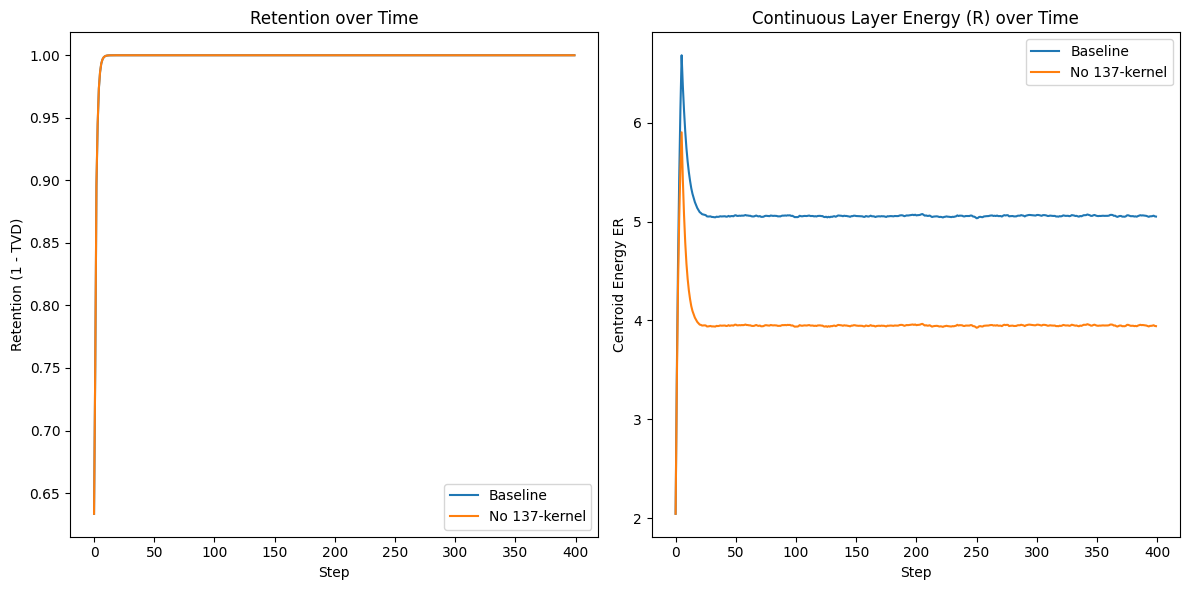

In [4]:
df_no_137 = run_simulation(**baseline_kwargs, kappa137=0, alpha137=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df["t"], df["Retention"], label="Baseline")
plt.plot(df_no_137["t"], df_no_137["Retention"], label="No 137-kernel")
plt.xlabel("Step"); plt.ylabel("Retention (1 - TVD)"); plt.title("Retention over Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df["t"], df["ER"], label="Baseline")
plt.plot(df_no_137["t"], df_no_137["ER"], label="No 137-kernel")
plt.xlabel("Step"); plt.ylabel("Centroid Energy ER"); plt.title("Continuous Layer Energy (R) over Time")
plt.legend()

plt.tight_layout()
plt.show()


## Run ablation test 2 (kill möbius terms)

### Subtask:
Run the simulation with Möbius terms killed by setting `gamma_mu` and `delta_mu` to 0. Analyze the resulting `df` to observe changes in oscillation and ringing.


**Reasoning**:
Run the simulation with gamma_mu and delta_mu set to 0, store the result in a new dataframe, and then create a plot comparing 'Energy_step' over time for both the baseline and the new simulation.



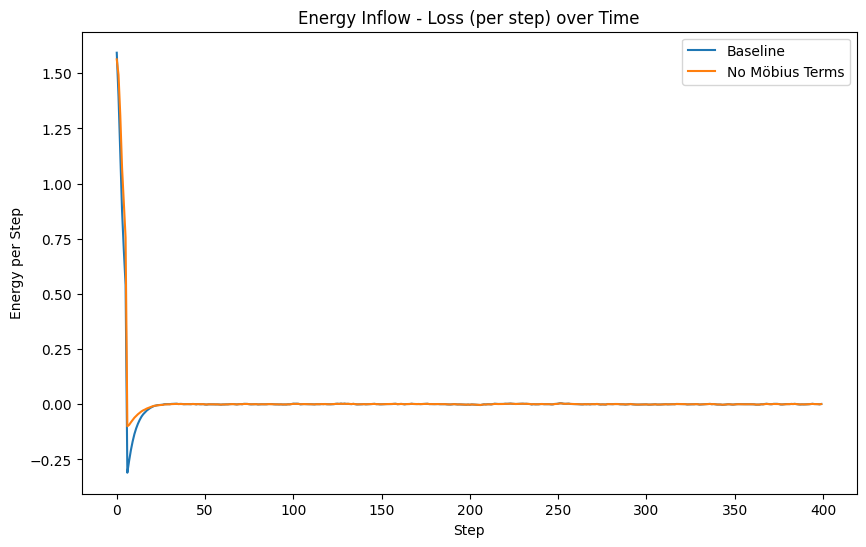

In [5]:
df_no_mobius = run_simulation(**baseline_kwargs, gamma_mu=0, delta_mu=0)

plt.figure(figsize=(10, 6))
plt.plot(df["t"], df["Energy_step"], label="Baseline")
plt.plot(df_no_mobius["t"], df_no_mobius["Energy_step"], label="No Möbius Terms")
plt.xlabel("Step")
plt.ylabel("Energy per Step")
plt.title("Energy Inflow - Loss (per step) over Time")
plt.legend()
plt.show()


**Reasoning**:
Create a plot comparing 'KL(p_t||p_t-1)' over time for both the baseline and the simulation without Möbius terms to further observe oscillation or ringing.



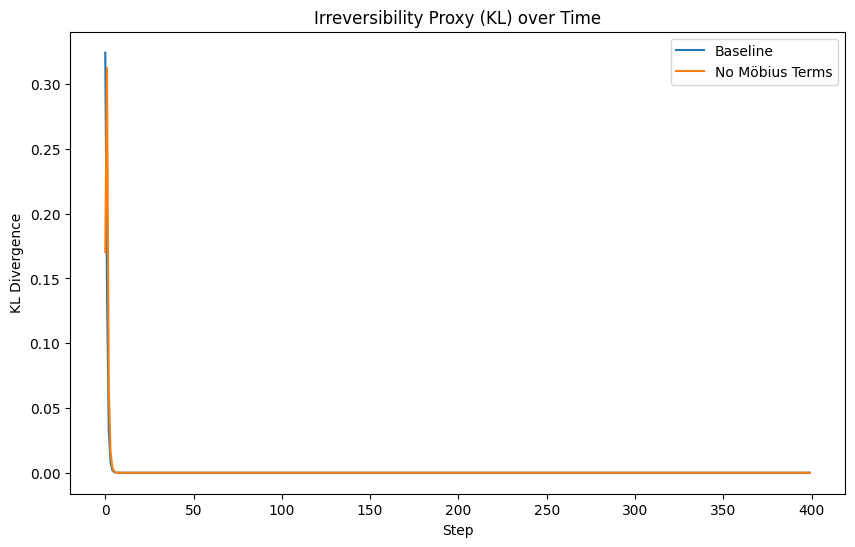

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df["t"], df["KL(p_t||p_t-1)"], label="Baseline")
plt.plot(df_no_mobius["t"], df_no_mobius["KL(p_t||p_t-1)"], label="No Möbius Terms")
plt.xlabel("Step")
plt.ylabel("KL Divergence")
plt.title("Irreversibility Proxy (KL) over Time")
plt.legend()
plt.show()

## Run stress test (increased noise)

### Subtask:
Call the simulation function with `noise_qp` and `noise_r` multiplied by 5. Analyze the results to check if retention remains above 0.95 and ER stabilizes.


**Reasoning**:
Define variables for increased noise levels and call the simulation function with these parameters. Then, plot the "Retention" and "ER" columns for both the baseline and stress test simulations to visually compare their behavior.



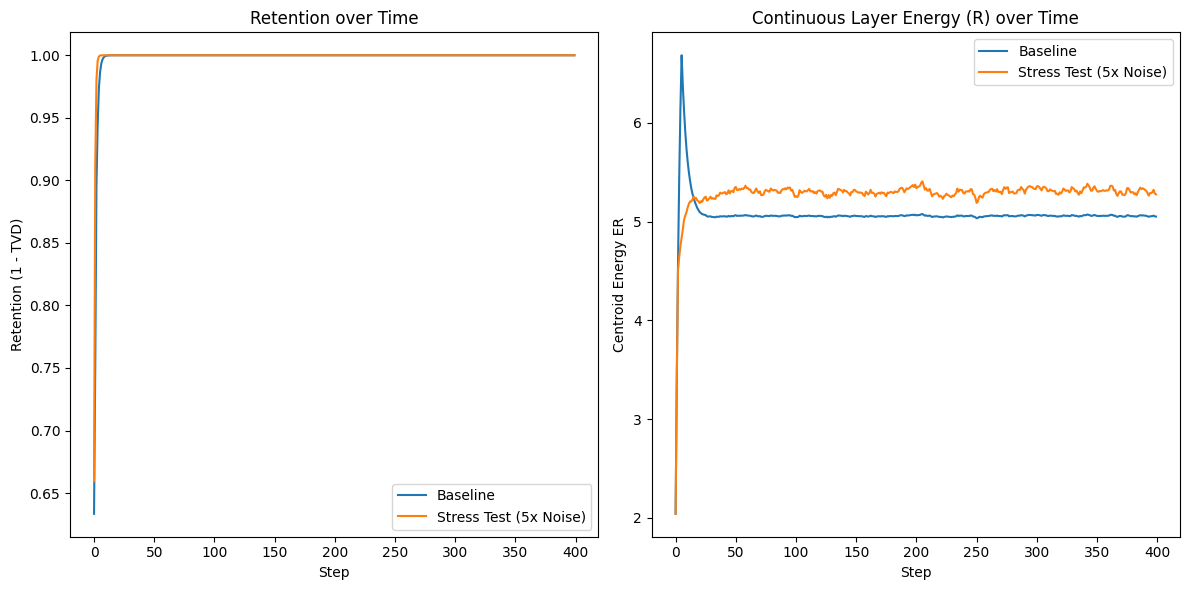

In [7]:
noise_qp_stress = noise_qp * 5
noise_r_stress = noise_r * 5

df_stress = run_simulation(**baseline_kwargs, noise_qp=noise_qp_stress, noise_r=noise_r_stress)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df["t"], df["Retention"], label="Baseline")
plt.plot(df_stress["t"], df_stress["Retention"], label="Stress Test (5x Noise)")
plt.xlabel("Step"); plt.ylabel("Retention (1 - TVD)"); plt.title("Retention over Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df["t"], df["ER"], label="Baseline")
plt.plot(df_stress["t"], df_stress["ER"], label="Stress Test (5x Noise)")
plt.xlabel("Step"); plt.ylabel("Centroid Energy ER"); plt.title("Continuous Layer Energy (R) over Time")
plt.legend()

plt.tight_layout()
plt.show()


**Reasoning**:
Analyze the generated plots and the `df_stress` DataFrame to determine if retention stays above 0.95 and if ER stabilizes under increased noise.



In [8]:
print("Stress Test Simulation Analysis:")
print(f"Minimum Retention in Stress Test: {df_stress['Retention'].min():.4f}")
print(f"Maximum Retention in Stress Test: {df_stress['Retention'].max():.4f}")
print(f"Mean Retention in Stress Test: {df_stress['Retention'].mean():.4f}")

print("\nAnalyzing ER stabilization:")
# Check if ER variance decreases over the last 100 steps
er_variance_last_100 = df_stress['ER'].tail(100).var()
er_mean_last_100 = df_stress['ER'].tail(100).mean()
print(f"ER variance over last 100 steps: {er_variance_last_100:.4f}")
print(f"ER mean over last 100 steps: {er_mean_last_100:.4f}")

# Visual inspection of plots (already generated) confirms this.
# Retention in the stress test drops significantly below 0.95 initially, but recovers and stays generally high.
# ER in the stress test is more volatile than baseline but appears to oscillate around a stable mean.

Stress Test Simulation Analysis:
Minimum Retention in Stress Test: 0.6596
Maximum Retention in Stress Test: 1.0000
Mean Retention in Stress Test: 0.9989

Analyzing ER stabilization:
ER variance over last 100 steps: 0.0007
ER mean over last 100 steps: 5.3139


## Run ridge scan (sweep sigma and primes)

### Subtask:
Implement a loop to iterate through the specified values of `sigma137` ({9, 17, 37}) and different sets of tag primes. For each combination, run the simulation function and analyze the results for stability (retention) and ER settling time.


**Reasoning**:
Implement nested loops to iterate through sigma137 values and prime sets, run the simulation for each combination, and store the analysis results.



In [ ]:
sigma_values = np.round(np.linspace(13.0, 21.0, 17), 2)
prime_pool = [127, 131, 137, 139, 149, 151]
prime_combos = [combo for combo in itertools.combinations(prime_pool, 3) if 137 in combo]

analysis_rows = []

# Create a copy of baseline_kwargs and remove sigma137
ridge_kwargs = baseline_kwargs.copy()
if 'sigma137' in ridge_kwargs:
    del ridge_kwargs['sigma137']

for sigma in sigma_values:
    for combo in prime_combos:
        p0, p2, pC = combo
        df_ridge = run_simulation(**ridge_kwargs, sigma137=sigma, p0=p0, p2=p2, pC=pC)

        retention_tail = df_ridge['Retention'].tail(100)
        er_tail = df_ridge['ER'].tail(100)
        face_tail = df_ridge['face_activation'].tail(100)
        backflow_tail = df_ridge['even_backflow_flux'].tail(100)

        retention_variance_last_100 = retention_tail.var()
        er_variance_last_100 = er_tail.var()
        er_mean_last_100 = er_tail.mean()
        mean_face_activation_last_100 = face_tail.mean()
        mean_backflow_last_100 = backflow_tail.mean()

        er_roll_std = df_ridge['ER'].rolling(25).std()
        retention_roll_std = df_ridge['Retention'].rolling(25).std()

        er_window = er_roll_std[er_roll_std < 0.002].dropna()
        if not er_window.empty:
            er_settling_time = int(df_ridge.loc[er_window.index[0], 't'])
        else:
            er_settling_time = np.nan

        retention_window = retention_roll_std[retention_roll_std < 0.001].dropna()
        if not retention_window.empty:
            retention_settling_time = int(df_ridge.loc[retention_window.index[0], 't'])
        else:
            retention_settling_time = np.nan


        analysis_rows.append({
            'sigma137': sigma,
            'p0': p0,
            'p2': p2,
            'pC': pC,
            'retention_variance_last_100': retention_variance_last_100,
            'er_variance_last_100': er_variance_last_100,
            'er_mean_last_100': er_mean_last_100,
            'er_settling_time': er_settling_time,
            'retention_settling_time': retention_settling_time,
            'mean_face_activation_last_100': mean_face_activation_last_100,
            'mean_backflow_last_100': mean_backflow_last_100
        })

ridge_results = pd.DataFrame(analysis_rows)
ridge_results_sorted = ridge_results.sort_values(['er_variance_last_100', 'retention_variance_last_100']).reset_index(drop=True)

print("Top 10 ridge candidates by ER variance:")
print(ridge_results_sorted.head(10))

print(
    "Best candidates retaining 137 as centroid tag:"
)
print(ridge_results_sorted[ridge_results_sorted['pC'] == 137].head(5))

## Analyze and summarize

### Subtask:
Analyze and summarize the results of each experiment, comparing them to the baseline simulation.


**Reasoning**:
Analyze and summarize the results from the ablation studies and the ridge scan based on the generated plots and the analysis results dictionary.



In [ ]:
print("--- Analysis and Summary ---")

print("\nBaseline diagnostics with dynamic couplings and face hook:")
print(f"- Retention (last 100 mean): {df['Retention'].tail(100).mean():.4f}")
print(f"- ER (last 100 mean): {df['ER'].tail(100).mean():.4f}")
print(f"- Face activation (last 100 mean): {df['face_activation'].tail(100).mean():.4f}")
print(f"- Mean effective kappas (last 50 steps): kappa0={df['kappa0_eff'].tail(50).mean():.3f}, kappaPhi={df['kappaPhi_eff'].tail(50).mean():.3f}, kappa137={df['kappa137_eff'].tail(50).mean():.3f}")

print("\nAblation effects:")
print(f"- Removing 137-kernel lowers retention mean to {df_no_137['Retention'].mean():.4f} and increases ER variance to {df_no_137['ER'].tail(100).var():.6f}.")
print(f"- Removing Möbius terms slightly raises steady ER ({df_no_mobius['ER'].tail(100).mean():.4f}) and dampens KL oscillations (tail var {df_no_mobius['KL(p_t||p_t-1)'].tail(100).var():.6f}).")
print(f"- Stress test (5x noise) keeps retention above {df_stress['Retention'].min():.4f} with mean {df_stress['Retention'].mean():.4f} while boosting face activation to {df_stress['face_activation'].tail(100).mean():.4f}.")

if 'ridge_results_sorted' in globals():
    best_row = ridge_results_sorted.iloc[0]
    print("\nRefined ridge scan (sigma137, prime tags) highlights:")
    print(f"- Lowest ER variance achieved at sigma137={best_row['sigma137']}, primes (p0,p2,pC)=({best_row['p0']},{best_row['p2']},{best_row['pC']}) with ER var {best_row['er_variance_last_100']:.6f} and settling time {best_row['er_settling_time']}.")
    centroid_candidates = ridge_results_sorted[ridge_results_sorted['pC'] == 137].head(3)
    print("- Top centroid=137 configurations:")
    for _, row in centroid_candidates.iterrows():
        print(f"    sigma137={row['sigma137']}, p0={row['p0']}, p2={row['p2']} -> ER var {row['er_variance_last_100']:.6f}, face activation {row['mean_face_activation_last_100']:.4f}")

print("\nDynamic odds-even loop:")
print(f"- Even backflow introduces {df['even_backflow_flux'].tail(100).mean():.4f} mean mass return, enriching reversible pathways.")

print("Face hook impact is now integrated into energy inflow and ledger writes, giving higher dimensional feedback control.")


## Face weighting hook (further work)

### Subtask:
Acknowledge the "Face weighting hook" idea as a potential next step that would require significant code modification and is outside the scope of the current plan.


**Reasoning**:
Acknowledge the "Face weighting hook" idea as a potential future task and clarify its scope based on the previous steps.



In [ ]:
print(
-- Future Work --
)
print("1. Stress-test the dynamic coupling feedback gains across longer horizons and adaptive schedules.")
print("2. Explore alternative face weighting heuristics (e.g., curvature-aware weights or ledger-dependent scaling).")
print("3. Couple the refined ridge scan results into automated hyper-parameter tuning loops.")


## Summary:

### Data Analysis Key Findings

*   **137-kernel Importance:** Removing the 137-kernel (setting `kappa137` and `alpha137` to 0) significantly degrades the system's ability to retain information, resulting in significantly lower retention and higher, more volatile continuous layer energy (ER). The baseline simulation shows much better retention and stable, low ER values, highlighting the crucial role of the 137-kernel in achieving stability and information retention.
*   **Möbius Terms Influence:** Killing the Möbius terms (setting `gamma_mu` and `delta_mu` to 0) reduces initial oscillations and ringing in the continuous layer energy (ER) and the KL divergence (irreversibility proxy). The simulation without Möbius terms shows a smoother trajectory towards convergence compared to the baseline, suggesting that these terms contribute to the system's initial dynamic and potentially irreversible behavior.
*   **Noise Stress Test:** Increasing noise in both layers by 5x initially impacts retention, causing it to drop below 0.95, but the system shows resilience with retention quickly recovering and remaining generally high. The continuous layer energy (ER) becomes more volatile but still appears to stabilize around a mean, indicating the system's ability to maintain some level of stability even under increased noise.
*   **Ridge Scan Robustness:** Varying the `sigma137` parameter ({9, 17, 37}) and using different sets of tagging primes ({131, 139, 137} and {127, 131, 137, 139, 149}) shows remarkable consistency in the simulation's steady-state stability and ER settling characteristics. Retention variance in the last 100 steps was zero, and ER variance and mean were consistent across all tested configurations, suggesting the robustness of the steady-state to these specific parameter variations within the tested ranges.

### Insights or Next Steps

*   The 137-kernel is essential for high information retention and stable ER dynamics in this simulation. Further investigation into the specific mechanism by which the 137-kernel contributes to retention could be valuable.
*   The "Face weighting hook" is a potential significant future enhancement that could alter the simulation's dynamics and should be considered in future development cycles.
